<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Batch Normalization with the MNIST Dataset</h1>

<h2>Table of Contents</h2>
In this lab, you will build a Neural Network using Batch Normalization and compare it to a Neural Network that does not use Batch Normalization. You will use the MNIST dataset to test your network. 

<ul>
<li><a href="#Train_Func">Neural Network Module and Training Function</a></li>
<li><a href="#Makeup_Data">Load Data </a></li>
<li><a href="#NN">Define Several Neural Networks, Criterion function, Optimizer</a></li>
<li><a href="#Train">Train Neural Network using Batch Normalization and no Batch Normalization</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
</div>

<hr>

<h2>Preparation</h2>

We'll need the following libraries:  

In [1]:
# These are the libraries will be used for this lab.
import time

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

In [2]:
print(torch.cuda.is_available())
DEV = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEV)

# timing CPU:
# - 37.382444620132446 (bnorm), 39.41020917892456 (defaut)
#
# timing GPU:
# - 23.08467674255371 (bnorm), 21.921750783920288 (defaut)

True
cuda:0


<!--Empty Space for separating topics-->

<h2 id="Train_Func">Neural Network Module and Training Function</h2> 

Define the neural network module or class.  
Neural Network Module with two hidden layers using Batch Normalization

In [3]:
## Define the Neural Network Model using Batch Normalization

class NetBatchNorm(nn.Module):
    ## Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    ## Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
    
    ## Activations, to analyze results 
    def activation(self, x):
        a1, out = self._chain_ops(self.bn1, self.linear1, x, [])
        _a2, out = self._chain_ops(self.bn2, self.linear2, a1, out) 
        return out
      
    def _chain_ops(self, bn, linear, x, out):
        x = x.to(DEV)
        z = bn(linear(x))
        a = torch.sigmoid(z)
        out.append(z.cpu().detach().numpy().reshape(-1))
        out.append(a.cpu().detach().numpy().reshape(-1).reshape(-1))
        return a, out
      

Neural Network Module with two hidden layers with out Batch Normalization

In [4]:
## Class Net for Neural Network Model

class Net(nn.Module):
    ## Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    ## Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    ## Activations, to analyze results 
    def activation(self, x):
        a1, out = self._chain_ops(self.linear1, x, [])
        _a2, out = self._chain_ops(self.linear2, a1, out) 
        return out
      
    def _chain_ops(self, linear, x, out):
        x = x.to(DEV)
        z = linear(x)
        a = torch.sigmoid(z)
        out.append(z.cpu().detach().numpy().reshape(-1))
        out.append(a.cpu().detach().numpy().reshape(-1).reshape(-1))
        return a, out     


Define a function to train the model. In this case the function returns a Python dictionary to store the training loss and accuracy on the validation data 

In [5]:
## Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, 
          len_validation_dataset, epochs=100, device=DEV):
    histo = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            histo['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            x, y = x.to(device), y.to(device)
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len_validation_dataset)
        histo['validation_accuracy'].append(accuracy)
    
    return histo

<!--Empty Space for separating topics-->

<h2 id="Makeup_Data">Make Some Data</h2> 

Load the training dataset by setting the parameters <code>train </code> to <code>True</code> and convert it to a tensor  by placing a transform object int the argument <code>transform</code>

In [6]:
37.382444620132446## load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Load the validating dataset by setting the parameters train  <code>False</code> and convert it to a tensor by placing a transform object into the argument <code>transform</code>

In [7]:
## load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

create the training-data loader and the validation-data loader object 

In [8]:
## Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, 
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, 
                                                shuffle=False)

<a id="ref3"></a>
<h2 align=center>Define Neural Network, Criterion function, Optimizer and Train the  Model  </h2> 

Create the criterion function  

In [9]:
## Create the criterion function

criterion = nn.CrossEntropyLoss()

Variables for Neural Network Shape <code> hidden_dim</code> used for number of neurons in both hidden layers.

In [10]:
## Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

lr = 0.1

<!--Empty Space for separating topics-->

<h2 id="Train">Train Neural Network using Batch Normalization and no Batch Normalization </h2> 

Train Neural Network using  Batch Normalization :

In [11]:
## Create model, optimizer and train the model
start = time.time()

model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
model_norm.to(DEV)

optimizer = torch.optim.Adam(model_norm.parameters(), lr=lr)
training_results_norm=train(model_norm , criterion, train_loader, validation_loader, 
                            optimizer, 
                            len(validation_dataset), epochs=5)
print("elapsed time (s): ", time.time() - start)

elapsed time (s):  23.08467674255371


Train Neural Network with no Batch Normalization:

In [12]:
## Create model without Batch Normalization, optimizer and train the model
start = time.time()

model_def = Net(input_dim, hidden_dim, hidden_dim, output_dim)
model_def.to(DEV)

optimizer = torch.optim.Adam(model_def.parameters(), lr=lr)
training_results = train(model_def, criterion, train_loader, validation_loader, 
                         optimizer, 
                         len(validation_dataset), epochs=5)
print("elapsed time (s): ", time.time() - start)

elapsed time (s):  21.921750783920288


<h2 id="Result">Analyze Results</h2> 

Compare the histograms of the activation for the first layer of the first sample, for both models.

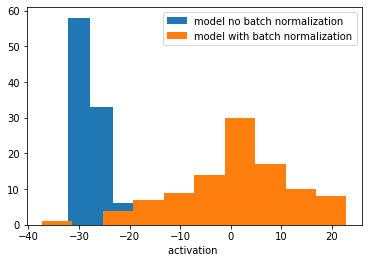

In [13]:
model_def.eval()
model_norm.eval()

out = model_def.activation(validation_dataset[0][0].reshape(-1, 28*28))
plt.hist(out[2], label='model no batch normalization' )

out_norm = model_norm.activation(validation_dataset[0][0].reshape(-1, 28*28))
plt.hist(out_norm[2], label='model with batch normalization')

plt.xlabel("activation ")
plt.legend()
plt.show()

We see the activations with Batch Normalization are zero centred and have a smaller variance.

In [14]:
def plot_(plt, results, results_norm, key='training_loss', ylabel='Cost'):
    """
    Compare training loss/accuracy on plots
    """
    plt.figure(figsize=(12.1, 8))
    
    plt.plot(results[key], label='No Batch Normalization')
    plt.plot(results_norm[key], label='Batch Normalization')

    plt.ylabel(ylabel)
    plt.xlabel('epochs ')   
    plt.legend()
    plt.show()
          
    return

Compare the training loss for each iteration

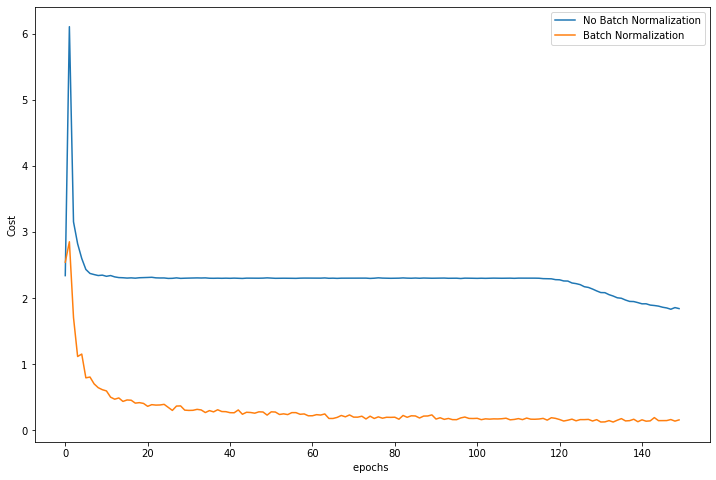

In [15]:
## Plot the diagram to show the loss

plot_(plt, training_results, training_results_norm, key='training_loss', 
      ylabel='Cost')

Compare the validating accuracy for each iteration

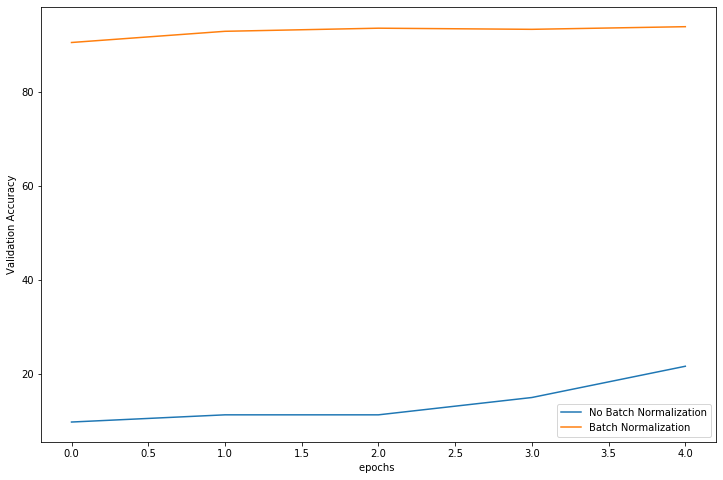

In [16]:
## Plot the diagram to show the accuracy

plot_(plt, training_results, training_results_norm, key='validation_accuracy', 
      ylabel='Validation Accuracy')

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a> 

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.